In [7]:
import pandas as pd
import numpy as np
import sys
import pickle
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import EvaluationModule
from ModelModule import models

import xgboost as xgb
import sklearn
from sklearn.model_selection import ShuffleSplit,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression

# Data Module

In [2]:
dataset = CoronnaCERTAINDataset(
    library_root = '/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge = 'binary_classification', #option: regression, regression_delta, classification, binary_classification, regression_delta_binary
    dataset = 'CORRONA CERTAIN', 
    process_approach = 'SC', #option: KVB, SC
    imputation = 'IterativeImputer', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group = ['bionaive TNF'], #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group = 'all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points = (0,3), 
    train_test_rate = 0.8,
    remove_low_DAS = True,
    save_csv = False, 
    random_state = 2022,
    verbose=False)

In [3]:
# read train, test from dataloader
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 327
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   grp                  304 non-null    int64  
 1   init_group           304 non-null    int64  
 2   age                  304 non-null    float64
 3   gender               304 non-null    int64  
 4   final_education      304 non-null    int64  
 5   race_grp             304 non-null    int64  
 6   ethnicity            304 non-null    int64  
 7   weight               304 non-null    float64
 8   BMI                  304 non-null    float64
 9   height               304 non-null    float64
 10  newsmoker            304 non-null    int64  
 11  drinker              304 non-null    int64  
 12  drinksperwk          304 non-null    float64
 13  duration_ra          304 non-null    float64
 14  ara_func_class       304 non-null    int64  
 15  num_tnf              304 non-null    flo

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 84
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   grp                  85 non-null     int64  
 1   init_group           85 non-null     int64  
 2   age                  85 non-null     float64
 3   gender               85 non-null     int64  
 4   final_education      85 non-null     int64  
 5   race_grp             85 non-null     int64  
 6   ethnicity            85 non-null     int64  
 7   weight               85 non-null     float64
 8   BMI                  85 non-null     float64
 9   height               85 non-null     float64
 10  newsmoker            85 non-null     int64  
 11  drinker              85 non-null     int64  
 12  drinksperwk          85 non-null     float64
 13  duration_ra          85 non-null     float64
 14  ara_func_class       85 non-null     int64  
 15  num_tnf              85 non-null     float

In [6]:
# get x,y train and test set
X_train = train.iloc[:,:-1] # train.iloc[:,-2]
y_train = train.iloc[:,-1] 
X_test = test.iloc[:,:-1] # test.iloc[:,-2]
y_test = test.iloc[:,-1]

In [6]:
# initialize evaluation module
aml = EvaluationModule.AutoBuild(seed=1, project_name="EHR_RA_SC", challenge=dataset.challenge, balance_class=1)

# Model Module

In [10]:
# modelmodule
# Xgb
if "regression" in dataset.challenge:
    model_id = 'xgb'
    save_path = f'../Models/{dataset.challenge}_{model_id}.pkl'
    
    model = xgb.XGBRegressor()
    shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=10, random_state=2022)
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, scoring="neg_mean_squared_error", cv=shuffle_split, verbose=0)
    model.fit(X_train, y_train)
    print("cross Validation scores:n {}".format(scores))
    print("Average Cross Validation score :{}".format(scores.mean()))
    # optional, to save and load models using pickle
#     pickle.dump(model, open(save_path, 'wb'))
#     model = pickle.load(open(save_path, 'rb'))
    
    aml.evaluate_explore(model_id, model, test)
elif "classification" in dataset.challenge:
    model = xgb.XGBClassifier(use_label_encoder=False)
    shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=10, random_state=2022)
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, scoring="accuracy", cv=shuffle_split, verbose=0)
    model.fit(X_train, y_train)
    aml.evaluate_explore("xgb", model, test)
    print("cross Validation scores:n {}".format(scores))
    print("Average Cross Validation score :{}".format(scores.mean()))

[17:37:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:57] WARNING: /Users/runner/miniforge3/c

In [11]:
# linear model
if "regression" in dataset.challenge:
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    aml.evaluate_explore("RF", model, test) # input: model and test
elif "classification" in dataset.challenge:
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    aml.evaluate_explore("RF", model, test) # input: model and test

In [12]:
X_test

,grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,...,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M
0,0,0,62.0,1,0,7,1,219.0,28.114865,74.0,...,3.0,35.0,10.0,0.000000,10.0,4.41,284.000000,1640.000000,94.000000,3.444942
1,1,0,54.0,0,2,7,1,160.0,26.622485,65.0,...,7.0,65.0,70.0,0.750000,60.0,51.51,462.000000,939.000000,49.000000,5.588392
2,1,0,42.0,1,0,7,1,185.0,26.541837,70.0,...,8.0,39.0,35.0,0.000000,35.0,5.30,231.000000,1340.000000,118.000000,4.156756
3,2,0,72.0,0,2,7,1,152.0,24.530762,66.0,...,6.0,50.0,65.0,0.857143,50.0,4.75,657.000000,1480.000000,317.000000,4.437767
4,1,0,42.0,0,0,7,1,239.0,38.571396,66.0,...,3.0,50.0,57.0,0.750000,63.0,56.12,192.000000,1810.000000,197.000000,4.819230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2,0,52.0,1,0,7,1,256.0,32.864865,74.0,...,4.0,25.0,30.0,0.000000,20.0,6.79,231.227041,1262.805531,71.569107,3.799023
81,1,0,62.0,0,0,1,1,273.0,45.424615,65.0,...,4.0,60.0,20.0,0.428571,50.0,2.01,561.000000,1410.000000,198.000000,3.316698
82,1,0,56.0,0,0,7,1,128.0,24.182747,61.0,...,7.0,70.0,60.0,0.142857,20.0,8.73,188.000000,1320.000000,138.000000,4.841508
83,3,0,74.0,1,0,7,1,230.0,31.190201,72.0,...,17.0,65.0,25.0,0.000000,25.0,1.35,168.000000,1360.000000,69.000000,5.080998


In [13]:
y_test

0     0
1     1
2     0
3     2
4     0
     ..
80    0
81    2
82    0
83    0
84    0
Name: DrugResponse, Length: 85, dtype: int64

In [14]:
aml.validate("rf", model, train, test)

before balancing class: 0    106
1    101
2     66
Name: DrugResponse, dtype: int64
before balancing class: 0    102
1    102
2     69
Name: DrugResponse, dtype: int64
before balancing class: 0    108
1    106
2     59
Name: DrugResponse, dtype: int64
before balancing class: 0    106
1     99
2     68
Name: DrugResponse, dtype: int64
before balancing class: 0    104
1    101
2     69
Name: DrugResponse, dtype: int64
before balancing class: 0    108
1    101
2     65
Name: DrugResponse, dtype: int64
before balancing class: 0    107
1    101
2     66
Name: DrugResponse, dtype: int64
before balancing class: 0    106
1    103
2     65
Name: DrugResponse, dtype: int64
before balancing class: 0    108
1    101
2     65
Name: DrugResponse, dtype: int64
before balancing class: 0    107
1    102
2     65
Name: DrugResponse, dtype: int64


In [15]:
aml.validation

,model,MAE,MSE,RMSE,R2,Pearson_Correlation,Accuracy,F1-Score
0,rf,None,None,None,None,None,0.387097,0.347339
1,rf,None,None,None,None,None,0.451613,0.409524
2,rf,None,None,None,None,None,0.419355,0.416863
3,rf,None,None,None,None,None,0.451613,0.344227
4,rf,None,None,None,None,None,0.366667,0.321425
5,rf,None,None,None,None,None,0.600000,0.586849
6,rf,None,None,None,None,None,0.466667,0.452778
7,rf,None,None,None,None,None,0.433333,0.432997
8,rf,None,None,None,None,None,0.300000,0.277336
9,rf,None,None,None,None,None,0.433333,0.433053


# Evaluation on test set

In [16]:
regression, classification = aml.leaderboard()

In [17]:
regression

In [18]:
classification

,model,Accuracy,F1-Score
0,xgb,0.458824,0.451899
1,RF,0.447059,0.431105


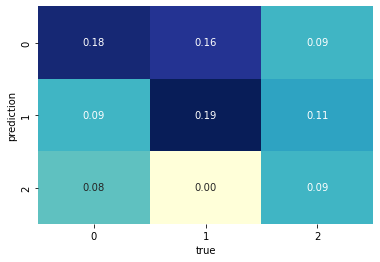

In [19]:
# rows: true, columns: pred
aml.confusion_matrix("xgb",plot=True, normalize=True)

In [20]:
# true
aml.saved_model['xgb'][0].value_counts()

0    30
1    30
2    25
Name: true, dtype: int64

In [21]:
# pred
aml.saved_model['xgb'][1].value_counts()

0    37
1    33
2    15
Name: pred, dtype: int64

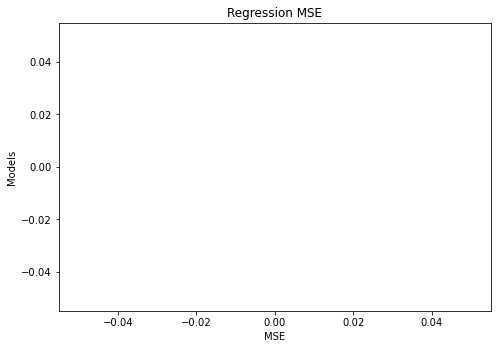

In [22]:
aml.plot_results('regression','MSE')

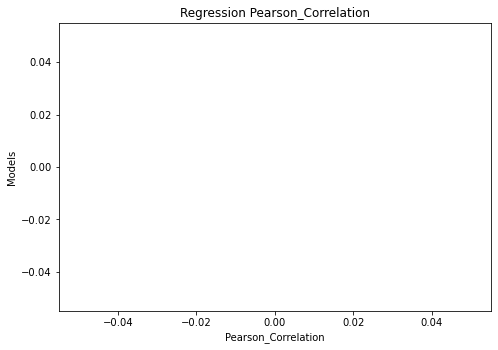

In [23]:
aml.plot_results('regression','Pearson_Correlation')

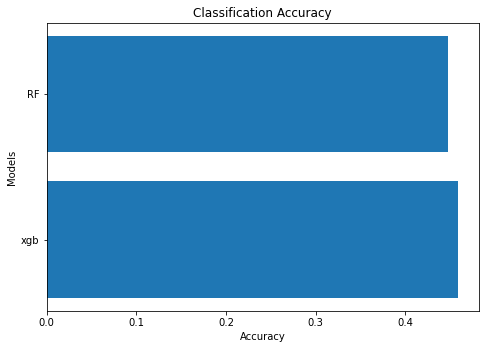

In [24]:
aml.plot_results('classification','Accuracy')

In [25]:
# aml.save_outputs(dataset,"../leaderboard")